In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org=pd.read_csv('data/house.csv')
house_df=house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
print(house_df.shape)
print(house_df.dtypes.value_counts())
isnull_series=house_df.isnull().sum()
print(isnull_series[isnull_series>0].sort_values(ascending=False))

(1460, 81)
object     43
int64      35
float64     3
dtype: int64
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


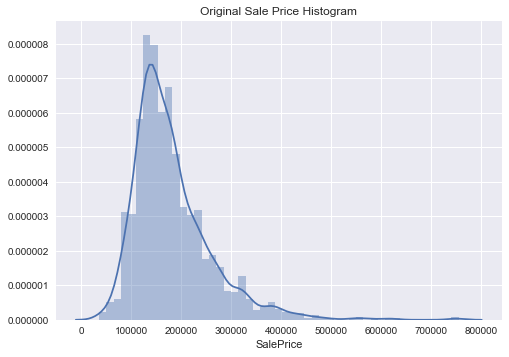

In [7]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])
plt.style.use('seaborn')

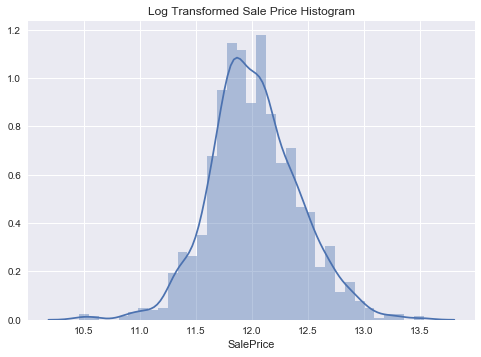

In [8]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [12]:
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)
house_df.fillna(house_df.mean(),inplace=True)

KeyError: "['Id' 'PoolQC' 'MiscFeature' 'Alley' 'Fence' 'FireplaceQu'] not found in axis"

In [16]:
null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]

In [23]:
house_df.dtypes[null_column_count.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [25]:
house_df_ohe=pd.get_dummies(house_df)
house_df_ohe.shape

(1460, 271)

In [29]:
house_df_ohe.isnull().sum().sum()

0

In [30]:
def get_rmse(model):
    pred=model.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print(model.__class__.__name__,'log_RMSE :',np.round(rmse,3))
    
def get_rmses(models):
    rmses=[]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [36]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,random_state=156,test_size=0.2)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
k=get_rmses(models)

LinearRegression log_RMSE : 0.01
Ridge log_RMSE : 0.01
Lasso log_RMSE : 0.018


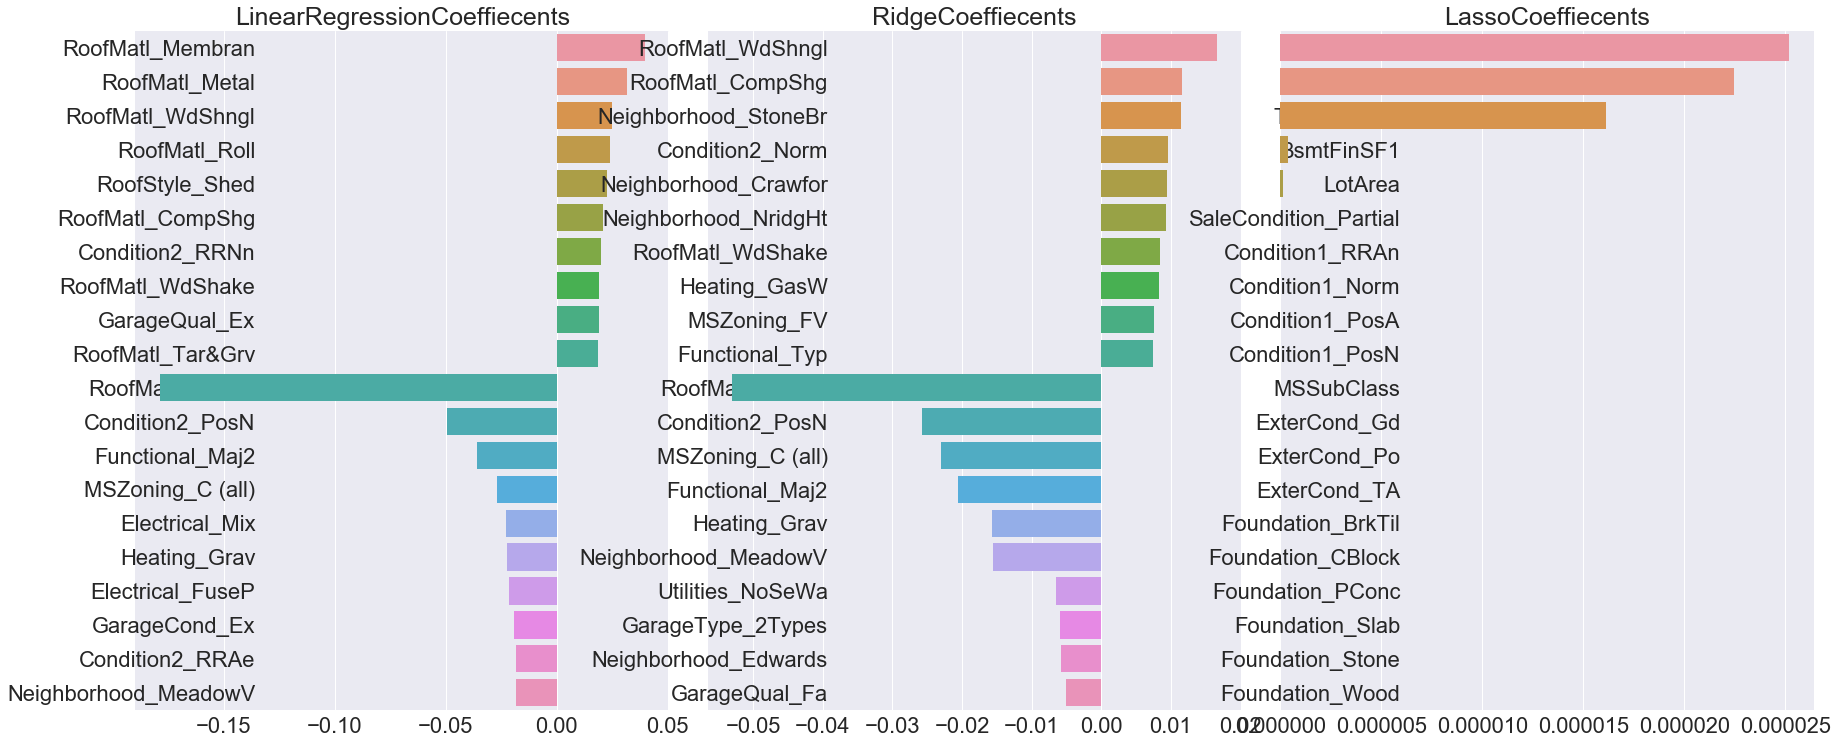

In [38]:
def get_top_bottom_coef(model,n=10):
    coef=pd.Series(model.coef_,index=X_features.columns)
    coef_high=coef.sort_values(ascending=False).head(n)
    coef_low=coef.sort_values(ascending=True).head(n)
    return coef_high,coef_low

def visualize_coefficient(models):
    fig,axs=plt.subplots(1,3,figsize=(24,10))
    fig.tight_layout()
    
    for i_num,model in enumerate(models):
        coef_high,coef_low=get_top_bottom_coef(model)
        coef_concat=pd.concat([coef_high,coef_low])
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
        axs[i_num].tick_params(axis='y',direction='in',pad=-120)
        
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index,ax=axs[i_num])
models=[lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)


In [41]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        rmse_list=np.sqrt(-cross_val_score(model,X_features,y_target,scoring='neg_mean_squared_error',cv=5))
        rmse_avg=np.mean(rmse_list)
        print('\n{} CV RMSE 값 리스트 : {}'.format(model.__class__.__name__,np.round(rmse_list,3)))
        print('{} CV RMSE 값 평균 : {}'.format(model.__class__.__name__,np.round(rmse_avg,3)))
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [0.011 0.013 0.013 0.009 0.015]
LinearRegression CV RMSE 값 평균 : 0.012

Ridge CV RMSE 값 리스트 : [0.009 0.012 0.011 0.009 0.014]
Ridge CV RMSE 값 평균 : 0.011

Lasso CV RMSE 값 리스트 : [0.016 0.019 0.018 0.017 0.022]
Lasso CV RMSE 값 평균 : 0.019


In [43]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model,params):
    grid_model=GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features,y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{} 5 CV 시 최적 평균 RMSE 값:{}, 최적 alpha:{}'.format(model.__class__.__name__,np.round(rmse,4),grid_model.best_params_))
ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.011, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.0126, 최적 alpha:{'alpha': 0.001}


LinearRegression log_RMSE : 0.01
Ridge log_RMSE : 0.01
Lasso log_RMSE : 0.011


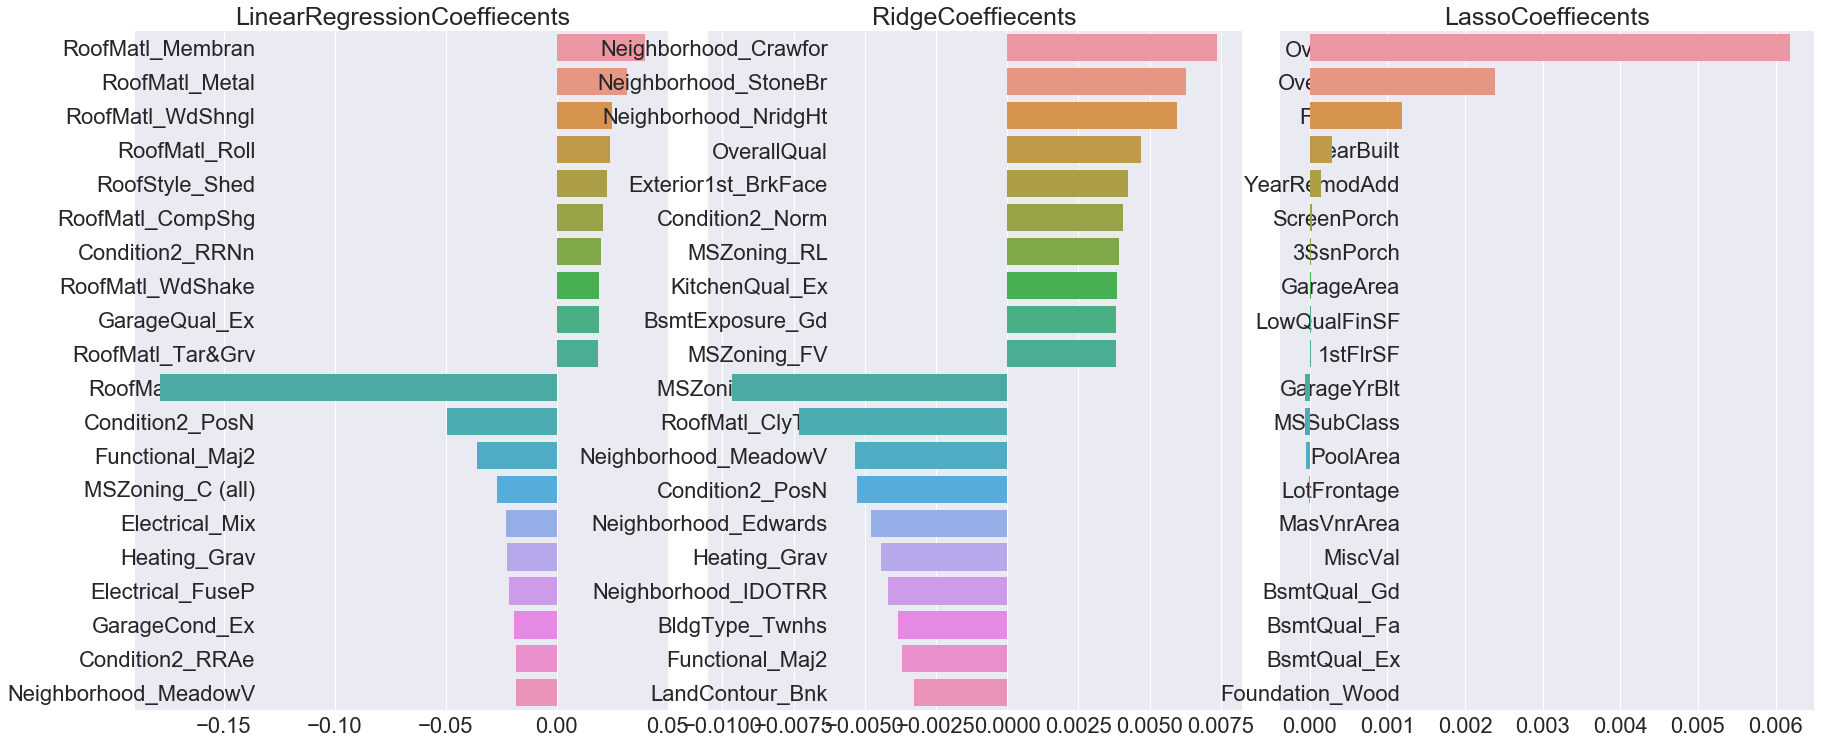

In [45]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [53]:
from scipy.stats import skew
features_index=house_df.dtypes[house_df.dtypes != 'object'].index
skew_features=house_df[features_index].apply(lambda x : skew(x))
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))


PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


In [51]:
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [54]:
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,random_state=156,test_size=.2)
ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값:0.0099, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.0121, 최적 alpha:{'alpha': 0.001}


LinearRegression log_RMSE : 0.01
Ridge log_RMSE : 0.01
Lasso log_RMSE : 0.012


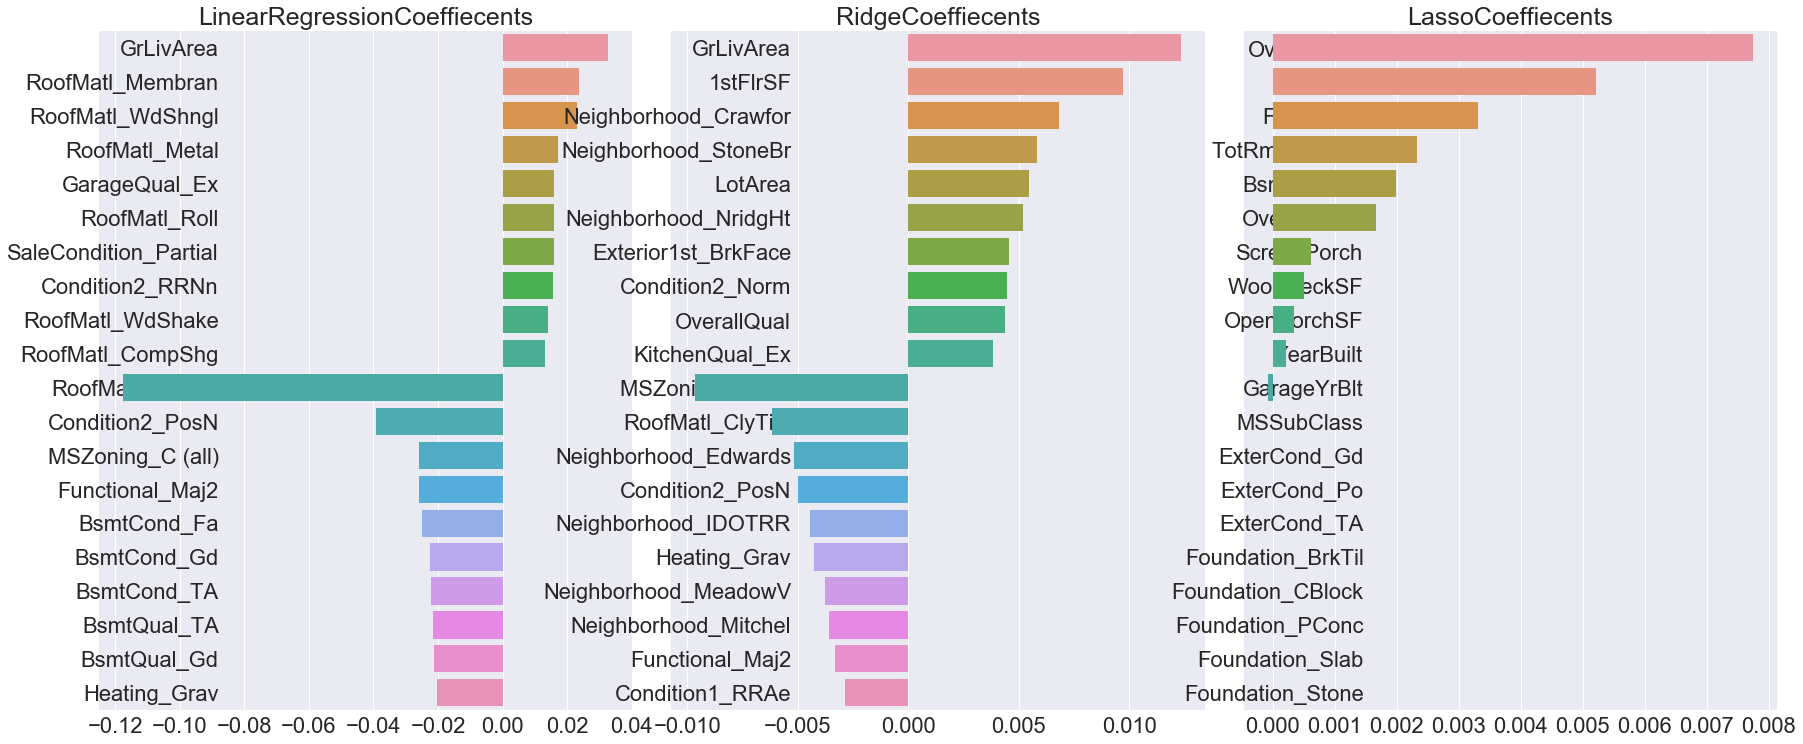

In [55]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

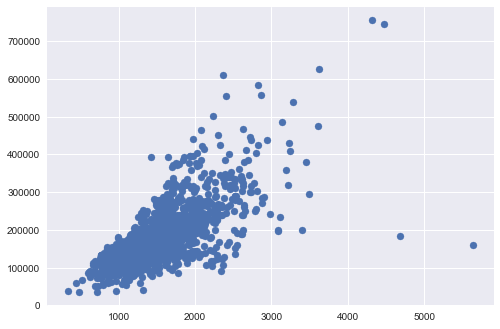

In [56]:
plt.scatter(x=house_df_org['GrLivArea'],y=house_df_org['SalePrice'])

In [58]:
cond1=house_df_ohe['GrLivArea']>np.log1p(4000)
cond2=house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index=house_df_ohe[cond1 & cond2].index

print('Outlier index:',outlier_index.values)
house_df.drop(outlier_index,axis=0,inplace=True)

Outlier index: [ 523  691 1182 1298]


In [59]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,random_state=156,test_size=.2)
ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값:0.0099, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.0121, 최적 alpha:{'alpha': 0.001}


In [60]:
from xgboost import XGBRegressor
xgb_params={'n_estimators':[1000]}
xgb_reg=XGBRegressor(n_estimators=1000,learning_reate=0.05,colsample_bytree=0.5,subsample=0.8)
print_best_params(xgb_reg,xgb_params)

[22:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:06:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:06:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:06:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:06:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.0095, 최적 alpha:{'n_estimators': 1000}


In [62]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value=preds[key]
        mse=mean_squared_error(y_test,pred_value)
        rmse=np.sqrt(mse)
        print('{}model RMSE:{}'.format(key,rmse))
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)
ridge_pred=ridge_reg.predict(X_test)
lasso_pred=lasso_reg.predict(X_test)
pred=0.4*ridge_pred+0.6*lasso_pred
preds={'최종 혼합':pred,'Ridge':ridge_pred,'Lasso':lasso_pred}
get_rmse_pred(preds)

최종 혼합model RMSE:0.010369127227778099
Ridgemodel RMSE:0.009499033627548899
Lassomodel RMSE:0.012004455520027114
